In [1]:
import os
import random
import yaml
import torch
import wandb
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Resize, Compose, Lambda

os.chdir("../")

from module.vqvae import VQVAE
from module.data import COCODataset, Transformer

/Users/deepak.dhull/mini/envs/dev/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
cfg = yaml.safe_load(open("config/vqvae.yaml", 'r'))

In [3]:
model = VQVAE(cfg)

/Users/deepak.dhull/mini/envs/dev/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/deepak.dhull/mini/envs/dev/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model.load_state_dict(torch.load("/tmp/model.pt", map_location='cpu'))

<All keys matched successfully>

In [5]:
import os

In [6]:
path = "/Users/deepak.dhull/practice/data/val2017"
files = os.listdir(path)

In [7]:
ds = COCODataset(cfg, path, files, disable_tansforms=True)

In [11]:
import random

9

In [34]:
_i = random.randint(0, 20)
for i, (img, _) in enumerate(ds):
    img = img
    if i == _i:
        break
# img, _ = next(iter(ds))

In [35]:
img.shape

torch.Size([3, 256, 256])

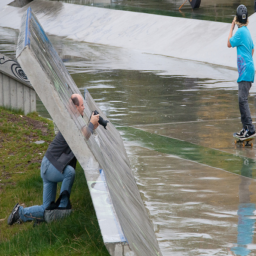

In [36]:
ToPILImage()(img*0.5 + 0.5)

In [37]:
with torch.no_grad():
    z, q_z = model.generate(img.unsqueeze(0))

In [38]:
_img = (z[0]*0.5 + 0.5)

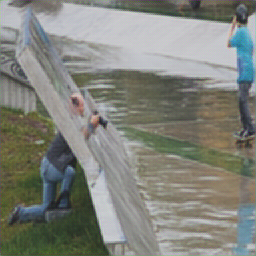

In [39]:
ToPILImage()(_img)

In [40]:
q_z.shape

torch.Size([1, 64, 64])

In [30]:
tmp = q_z

In [21]:
lookup_table = torch.randn(512, 128)
x = lookup_table[q_z.flatten()]

In [91]:
x = x.view(1, 64, 64, -1)
x.shape

torch.Size([1, 64, 64, 128])

In [92]:
indices = q_z
decay = 0.99

In [101]:
b, w, h, d = x.shape
x = x.view(-1, d)  # Flatten x to (b*w*h, d)
indices = indices.view(-1)  # Flatten indices to (b*w*h,)

In [111]:
x.shape,indices.shape

(torch.Size([4096, 128]), torch.Size([4096]))

In [104]:
cluster_size = torch.zeros(512)

In [102]:
# One-hot encode the indices
one_hot_assignments = torch.nn.functional.one_hot(indices, 512).float()

In [112]:
one_hot_assignments.shape

torch.Size([4096, 512])

In [103]:
# Compute new cluster sizes (soft counts with EMA)
new_cluster_size = one_hot_assignments.sum(dim=0)

In [105]:
cluster_size = decay * cluster_size + (1 - decay) * new_cluster_size

In [106]:
one_hot_assignments.shape, x.shape

(torch.Size([4096, 512]), torch.Size([4096, 128]))

In [107]:
# Compute new codebook vectors using EMA
weighted_sums = one_hot_assignments.T @ x  # Shape: (num_codebook_vectors, d)

In [108]:
lookup_table = decay * lookup_table + (1 - decay) * weighted_sums

In [109]:
# Normalize the codebook vectors to avoid collapsing
n = cluster_size.sum()  # Total number of assignments
cluster_size_norm = (cluster_size + 1e-5) / (n + 1e-5) * n
lookup_table = lookup_table / cluster_size_norm.unsqueeze(1).clamp(min=1e-5)